<h2 align="center">Predict Employee Churn with Decision Trees and Random Forests</h2>

### Introduction
---

Our focus here is on splitting the data, feature importance, training classifiers and reviewing results via a basic accuracy function. We will first import the necessary libraries for data manipulation and visualization. Perform an EDA using the ***pandas_profile*** module, and attempt to see if we can perform a quantile transformation to transform feature distributions into normal distributions. We will the class-imbalance between the employees that ***stayed*** and the employees that ***quit***, and take it into consideration while splitting the dataset into train and test sets. We will then train and implement a Random Forest Classifier together with a Decision Tree Classifier to correctly predict employee turnover state: ***quit*** or ***stay***. It will be shown that the Random Forest Classifer outperforms the Decision Tree Classifier. In addition to proving superior to the Decision Tree Classifer, the Random Forest Classifer outperforms the Logistic Regression algorhitm as well.

### Part 1: Import Libraries
---

Import the necessary libraries for data manipulation, preprocessing and visualization. The module ***pandas_profiling*** enables us to generate dataset statisics per feature. All warnings are disabled using the ***warnings*** module

In [4]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
import pandas_profiling as pp
plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [5]:
plt.rcParams['figure.figsize'] = (12,8)

### Part 2: Exploratory Data Analysis
---

Import the employee dataset, transform it into a pandas dataframe and display the first five values

In [6]:
hr = pd.read_csv('employee_data.csv')
hr_orig = hr
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Based on the Pearson's R correlation matrix as generated by the report, ***quit*** is negatively correlated wit ***satisfaction level***. The higher the satisfaction level, the lower the employee turnover rate.

In [5]:
hr.profile_report()


Some numeric features appear to come from different distriubtions. Let's attempt to perform a quantile transformation to see if we can consistenly transform these distributions to a normal distribution.

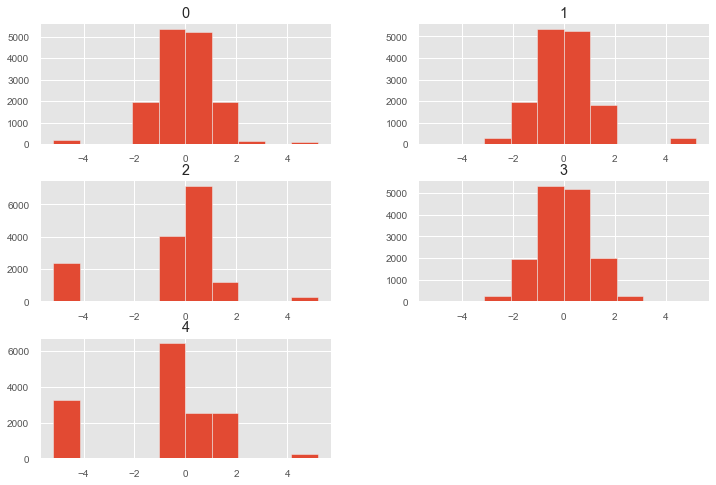

In [32]:
# visualize a uniform quantile transform of the sonar dataset
from pandas import read_csv
from pandas import DataFrame
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import QuantileTransformer
from matplotlib import pyplot
# load dataset
dataset = read_csv('employee_data.csv')
dataset['satisfaction_level'] = pd.to_numeric(dataset['satisfaction_level'], errors='coerce')
dataset['last_evaluation'] = pd.to_numeric(dataset['last_evaluation'], errors='coerce')
dataset['number_project'] = pd.to_numeric(dataset['number_project'], errors='coerce')
dataset['average_montly_hours'] = pd.to_numeric(dataset['average_montly_hours'], errors='coerce')
dataset['time_spend_company'] = pd.to_numeric(dataset['time_spend_company'], errors='coerce')
# retrieve just the numeric input values
data = dataset.values[:, :5]
# perform a uniform quantile transform of the dataset
trans = QuantileTransformer(n_quantiles=100, output_distribution='normal')
data = trans.fit_transform(data)
# convert the array back to a dataframe
dataset = DataFrame(data)
# histograms of the variables
dataset.hist()
pyplot.show()

Since not all of the features are consistently transformed, we will not pursue a quantie transformation.

### Part 3: Encode Categorical Features
---

In this part ***salary*** and ***department*** features will be one-hot encoded so that they can be fed into classification algorhitms appropriately. Firstly explore these features visually and then perform one-hot encoding

The turnover rate, the number of employees leaving the company vs the total number of employees, is higher for employees who have a low and medium tier salaries.

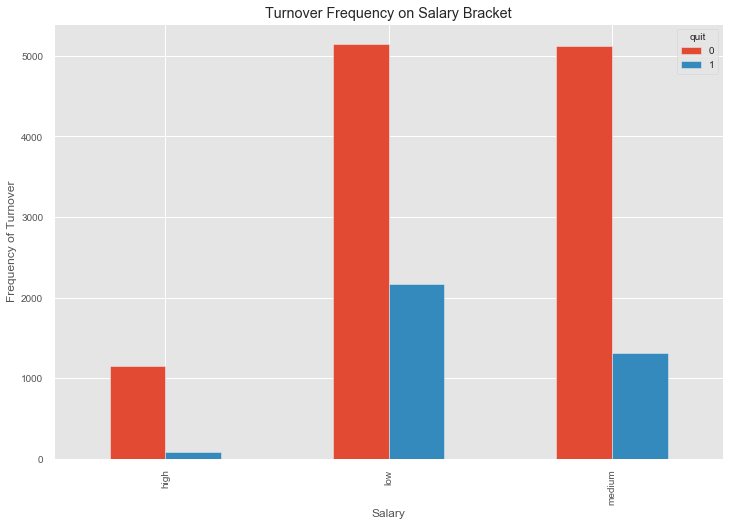

In [6]:
pd.crosstab(hr.salary,hr.quit).plot(kind='bar')
plt.title('Turnover Frequency on Salary Bracket')
plt.xlabel('Salary')
plt.ylabel('Frequency of Turnover')
plt.show()

Although the turnover rate appears to be proportionally higher in hr and accounting, it displays no significant difference across differrent departments.

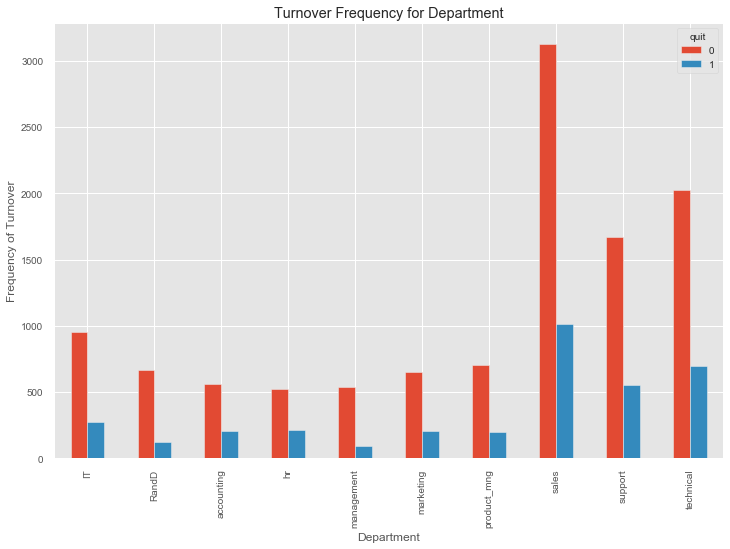

In [7]:
pd.crosstab(hr.department,hr.quit).plot(kind='bar')
plt.title('Turnover Frequency for Department')
plt.xlabel('Department')
plt.ylabel('Frequency of Turnover')
plt.show()

Perform one-hot encoding

In [7]:
cat_vars=['department','salary']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(hr[var], prefix=var)
    hr1=hr.join(cat_list)
    hr=hr1

In [8]:
hr.columns


Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'quit',
       'promotion_last_5years', 'department', 'salary', 'department_IT',
       'department_RandD', 'department_accounting', 'department_hr',
       'department_management', 'department_marketing',
       'department_product_mng', 'department_sales', 'department_support',
       'department_technical', 'salary_high', 'salary_low', 'salary_medium'],
      dtype='object')

In [9]:
hr.drop(columns=['department','salary'], axis=1, inplace=True)
#hr.drop(hr.columns[[8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]], axis=1, inplace=True)

### Part 4: Visualize Class Imbalance
---

The number of employees that stayed with the company exceed in proportion the number of employees who left the company. This situation engenders a class imbalance problem.


In [11]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

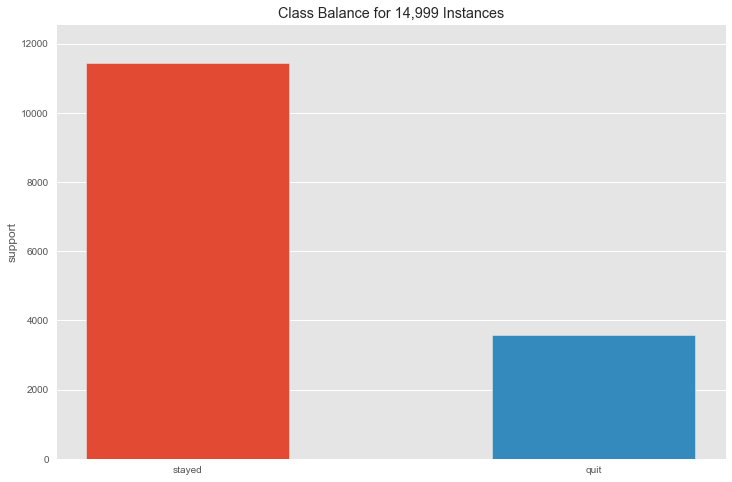

In [12]:
visualizer = ClassBalance(labels=["stayed", "quit"])

visualizer.fit(hr.quit)
visualizer.show();

### Task 5: Create Training and Test Sets
---

In order to handle the class imbalance problem, the ***stratify*** parameter of the ***train_test_split*** function to ***y***. This ensures that the train and test sets reflect this imbalance. Thus, since the ***stayed*** employees outnumber the ***quit*** employees 4 to 1 the train and test datasets will also be configured this way.

In [10]:
X = hr.loc[:, hr.columns != 'quit']
y = hr.quit

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,
                                                    stratify=y)

### Parts 6 & 7: Build an Interactive Decision Tree Classifier
---

#### Decision trees:

 - Decision trees are non-parametric models which can model arbitrarily complex relations between inputs and outputs, without any a priori assumption
 
- Decision trees handle numeric and categorical variables

- They implement feature selection, making them robust to noisy features (to an extent)

- Robust to outliers or errors in labels

- Easily interpretable by even non-ML practioners.

- Decision trees generally have low bias but have high variance.

In [12]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

A Decision Tree Classifier with depth 4, min split 2 and min leaf 1 acquire 0.969 accuracy on both test and train datasets.

In [13]:
@interact
def plot_tree(crit=["gini", "entropy"],
              split=["best", "random"],
              depth=IntSlider(min=1,max=30,value=2, continuous_update=False),
              min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    
    estimator = DecisionTreeClassifier(random_state=0,
                                       criterion=crit,
                                       splitter = split,
                                       max_depth = depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf)
    estimator.fit(X_train, y_train)
    print('Decision Tree Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Decision Tree Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))

    graph = Source(tree.export_graphviz(estimator,
                                        out_file=None,
                                        feature_names=X_train.columns,
                                        class_names=['0', '1'],
                                        filled = True))
    
    display(Image(data=graph.pipe(format='png')))
    
    return estimator


interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Task 8: Build an Interactive Random Forest Classifier
---

Although randomization increases bias, it is possible to get a reduction in variance of the ensemble. Random forests are one of the most robust machine learning algorithms for a variety of problems.

- Randomization and averaging lead to a reduction in variance and improve accuracy
- The implementations are parallelizable
- Memory consumption and training time can be reduced by bootstrapping
- Sampling features and not solely sampling examples is crucial to improving accuracy

A Random Forest Classifer, with depth = 9, forests = 100, min_split=2, and min_leaf=2 acquires 0.979 accuarcy on train set and 0.977 accuracy on test set.

In [14]:
@interact
def plot_tree_rf(crit=["gini", "entropy"],
                 bootstrap=["True", "False"],
                 depth=IntSlider(min=1,max=30,value=3, continuous_update=False),
                 forests=IntSlider(min=1,max=200,value=100,continuous_update=False),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    
    estimator = RandomForestClassifier(random_state=1,
                                       criterion=crit,
                                       bootstrap=bootstrap,
                                       n_estimators=forests,
                                       max_depth=depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf,
                                       n_jobs=-1,
                                      verbose=False).fit(X_train, y_train)

    print('Random Forest Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Random Forest Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))
    num_tree = estimator.estimators_[0]
    print('\nVisualizing Random Forest:', 0)
    
    graph = Source(tree.export_graphviz(num_tree,
                                        out_file=None,
                                        feature_names=X_train.columns,
                                        class_names=['0', '1'],
                                        filled = True))
    
    display(Image(data=graph.pipe(format='png')))
    
    return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Part 9: Feature Importance and Evaluation Metrics
---

As expected from Part 2, Exploratory Data Analysis, satisfaction_level appears to be most important feature to predict churn for both models. The other features of relative importance for the Random Forest Classifier are number of projects completed by the employee, average monthly hours comitted to work, and time spent in the company.

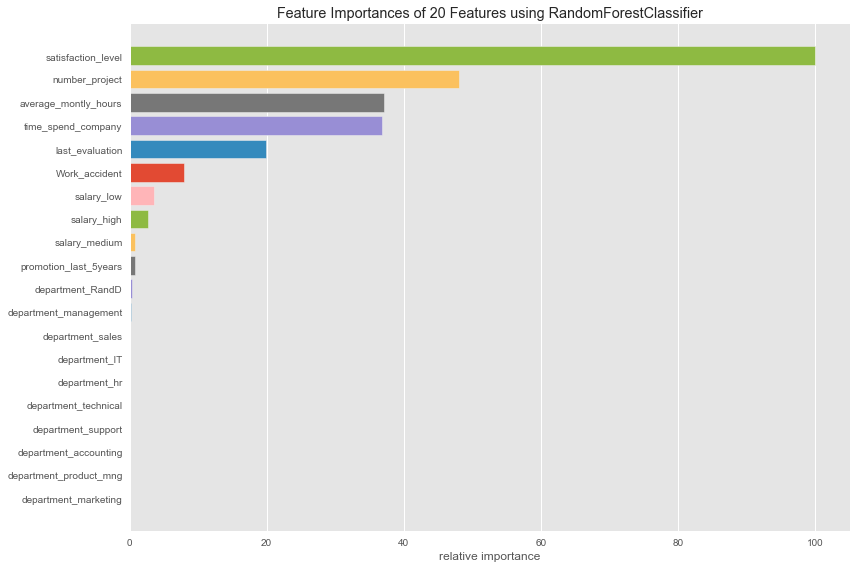

In [20]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

rf = RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=False,
            warm_start=False)

viz = FeatureImportances(rf)
viz.fit(X_train, y_train)
viz.show();

The other features of relative importance for the Decision Tree Classifier are time spent in the company, and number of projects completed by the employee.

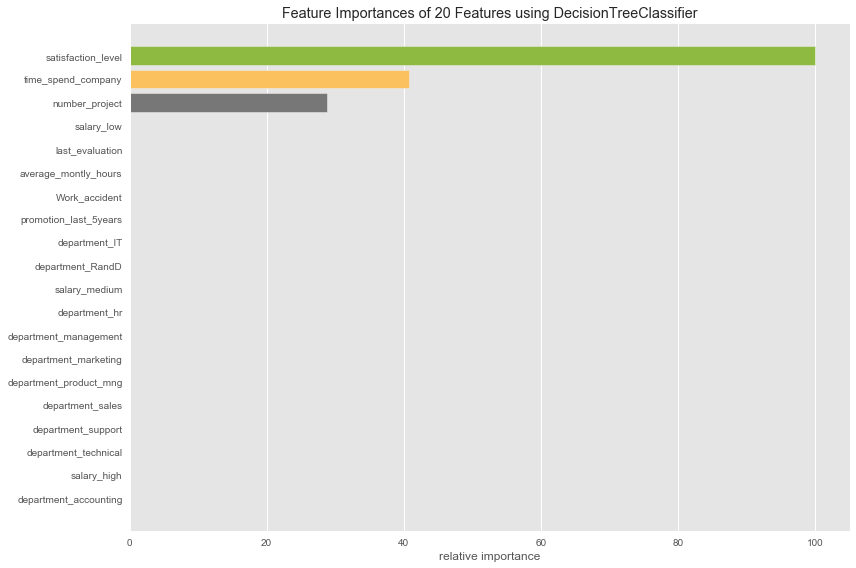

In [21]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

dt = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

viz = FeatureImportances(dt)
viz.fit(X_train, y_train)
viz.show();

When compared with the Decision Tree Classifier and Logstic Regression the Random Forest Classifer displays the highest area under the ROC curve.

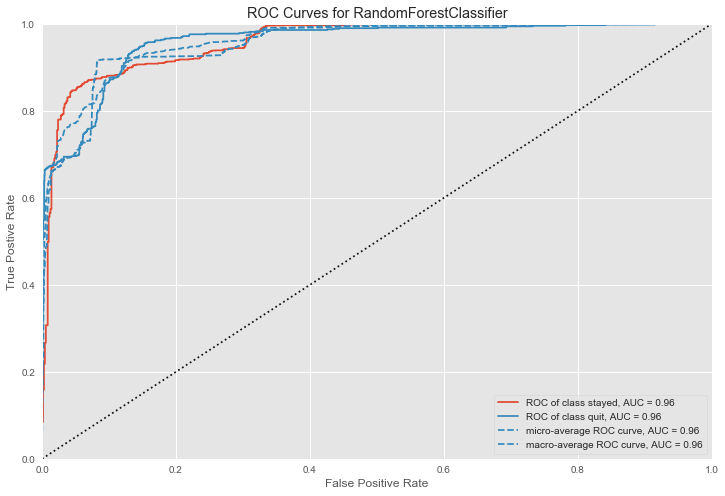

In [22]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rf, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

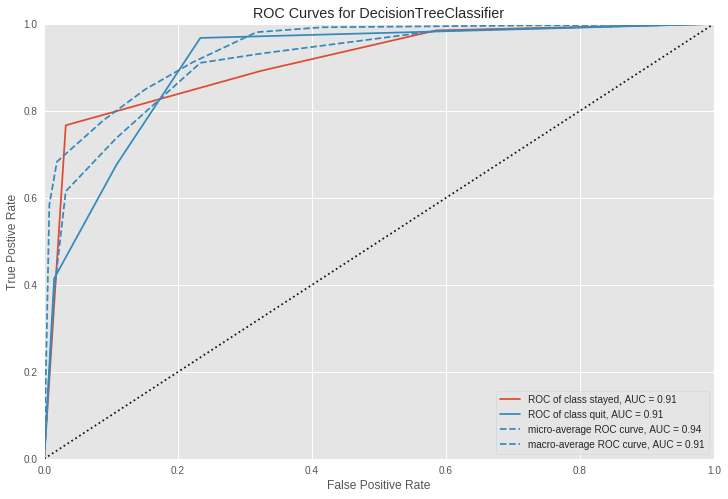

In [18]:
dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

visualizer = ROCAUC(dt, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

### Comparison with Logistic Regression Classifier
---

Logistic Regression Accuracy: 0.790


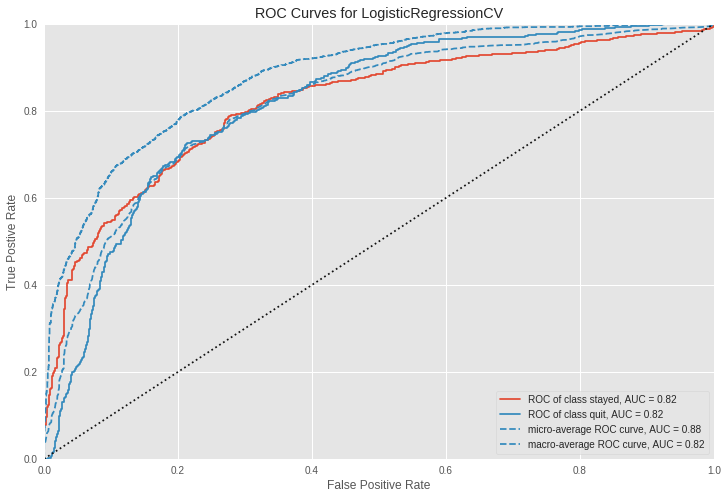

In [19]:
from sklearn.linear_model import LogisticRegressionCV

logit = LogisticRegressionCV(random_state=1, n_jobs=-1,max_iter=500,
                             cv=10)

lr = logit.fit(X_train, y_train)

print('Logistic Regression Accuracy: {:.3f}'.format(accuracy_score(y_test, lr.predict(X_test))))

visualizer = ROCAUC(lr, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

### Part 10: Conclusion
---

In this study three classification models were implemented and compared: Logistic Regression, Decision Trees and Random Forests. Among them a Random Forest Classifer with depth = 9, forests = 100, min_split=2, and min_leaf=2 acquired 0.979 accuarcy on train set and 0.977 accuracy on test set, and displayed the best performance.